In [1]:
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('stockmarket.csv')
df.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


In [3]:
import datetime
import calendar

def Date_trans(row):
    temp = row["Date"].split("-")
    temp[1] = list(calendar.month_abbr).index(temp[1])
    y = "-".join('%s' %id for id in temp)
    y = datetime.datetime.strptime(y, '%d-%m-%Y')
    return y

df["Date_T"] = df.apply (Date_trans , axis = 1)    
df.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume,Date_T
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080,2009-01-02
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016,2009-01-05
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032,2009-01-06
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032,2009-01-07
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952,2009-01-08


In [4]:
def Train_Test(row):
    y = row["Date_T"].year
    if y < 2018:
        return "T"
    else:
        return "F"

df["Train"] = df.apply (Train_Test , axis = 1)    

In [5]:
def ToStamp(row):
    y = datetime.datetime.timestamp(row["Date_T"])
    return y

df["Time"] = df.apply (ToStamp , axis = 1)           

Year, month, date, Q(season) seperation

In [6]:
def YearSep(row):
    y = row["Date_T"].year
    return y
    
def MonthSep(row):
    m = row["Date_T"].month
    return m
    
def DateSep(row):
    d = int(row["Date"].split("-")[0])
    return d
    
def QDecide(row):
    if row["Month"] <= 3:
        s = 1
    elif row["Month"] <= 6:
        s = 2
    elif row["Month"] <= 9:
        s = 3
    else:
        s = 4
    return s
        

df["Year"] = df.apply (YearSep , axis = 1)
df["Month"] = df.apply (MonthSep , axis = 1)
df["Day"] = df.apply (DateSep , axis = 1)
df["Q"] = df.apply (QDecide , axis = 1)

In [7]:
def Rise_Fall_P(row):
    P = (row["Close Price"]/row["Open Price"]-1)*100
    return P

df["Diff"] = df.apply (Rise_Fall_P , axis = 1)

In [8]:
df.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume,Date_T,Train,Time,Year,Month,Day,Q,Diff
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080,2009-01-02,T,1.230826e+09,2009,1,2,1,3.190512
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016,2009-01-05,T,1.231085e+09,2009,1,5,1,-0.185111
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032,2009-01-06,T,1.231171e+09,2009,1,6,1,0.379093
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032,2009-01-07,T,1.231258e+09,2009,1,7,1,-2.242709
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952,2009-01-08,T,1.231344e+09,2009,1,8,1,0.441633


In [9]:
DataRe = df.drop(["Date", "Close Price", "Date_T", "Time"], axis=1)
DataRe_train = DataRe[DataRe["Train"] == "T"].drop(["Train"], axis=1)
DataRe_test = DataRe[DataRe["Train"] == "F"].drop(["Train"], axis=1)

In [10]:
x_train = DataRe_train.loc[:, DataRe_train.columns != "Diff"]
y_train = DataRe_train["Diff"]
x_test = DataRe_test.loc[:, DataRe_test.columns != "Diff"]
y_test = DataRe_test["Diff"]
model = linear_model.LinearRegression(normalize=True)
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [11]:
train_pred = model.predict(x_train)
mse_train = metrics.mean_squared_error(y_train, train_pred)
print(mse_train)

0.23126321587529627


In [12]:
np.sqrt(mse_train)

0.4808983425582753

In [13]:
test_pred = model.predict(x_test)
test_mse = metrics.mean_squared_error(y_test, test_pred)
print('test MSE: %s' % test_mse)
print('test RMSE: %s' % np.sqrt(test_mse))

test MSE: 0.48492930441838533
test RMSE: 0.696368655539855


In [14]:
x_train.columns

Index(['Open Price', 'High Price', 'Low Price', 'Volume', 'Year', 'Month',
       'Day', 'Q'],
      dtype='object')

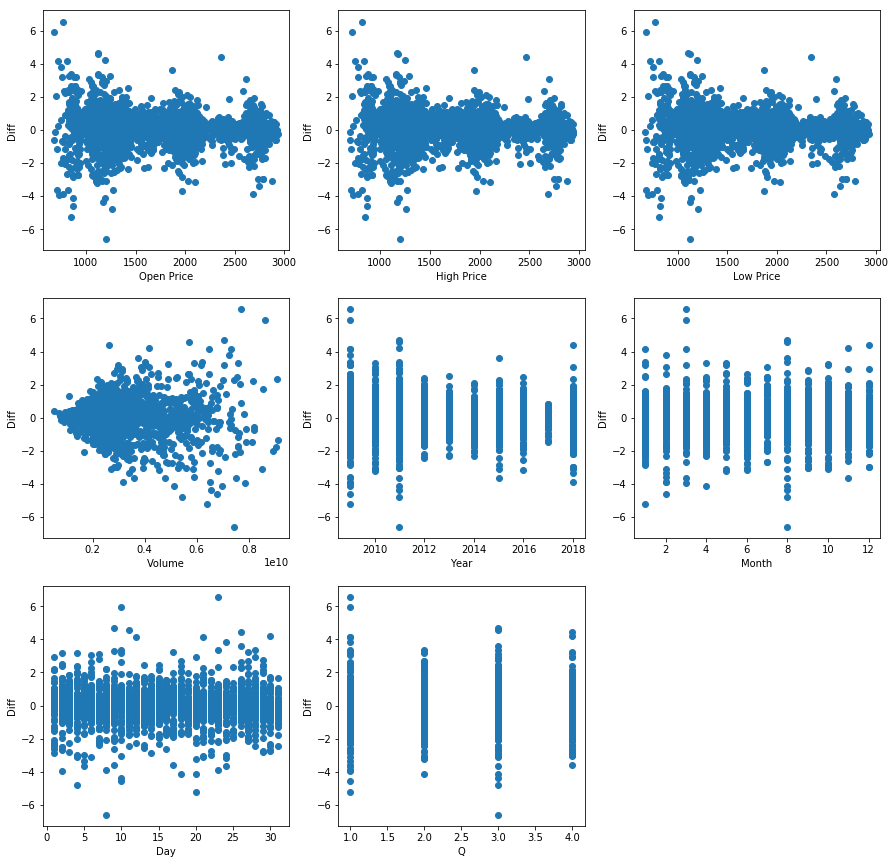

In [15]:
def scatter(_data, x_name):
    plt.scatter(_data[x_name], _data["Diff"])
    plt.xlabel(x_name)
    plt.ylabel("Diff")
    
plt.figure(figsize=(15,15))    
for i in range(len(x_train.columns)):
    plt.subplot(3,3,i+1)
    scatter(DataRe, x_train.columns[i])
plt.show()   

In [16]:
###Ridge Regression
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.mean_squared_error(y, preds)

In [17]:
alphas = np.linspace(start=0, stop=0.01, num=11)
alphas

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 ])

In [18]:
mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, x_train, y_train, cv=10, scoring=scorer)
    mses.append(mse.mean())

In [19]:
mses

[0.25737711942586483,
 0.7769286451787534,
 0.8633998585176276,
 0.8970427305944426,
 0.9148951372934542,
 0.9259404200176762,
 0.933435636766631,
 0.9388464296232654,
 0.9429296105922328,
 0.9461153954407886,
 0.9486663932938966]

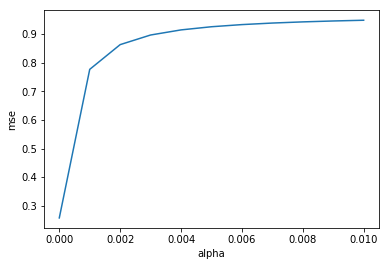

In [20]:
plt.plot(alphas, mses)
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [21]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.0

In [22]:
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(x_train, y_train)
train_preds = ridge.predict(x_train)
test_preds = ridge.predict(x_test)
train_mse = metrics.mean_squared_error(y_train, train_preds)
test_mse = metrics.mean_squared_error(y_test, test_preds)
print('Train MSE: %s' % train_mse)
print('Test MSE: %s' % test_mse)

Train MSE: 0.23126321587529597
Test MSE: 0.48492930442141774


In [23]:
for i in range(0, len(DataRe_train.columns) - 1):
    print('Coefficient for %s:%s\t%s' %
          (DataRe_train.columns[i], 
           '\t' if len(DataRe_train.columns[i]) < 7 else '',
           ridge.coef_[i]))

Coefficient for Open Price:	-0.11152465407020382
Coefficient for High Price:	0.05983247156222324
Coefficient for Low Price:	0.051649806881101476
Coefficient for Volume:		-8.064666623183236e-12
Coefficient for Year:		0.002154287409575826
Coefficient for Month:		-0.03093796851986052
Coefficient for Day:		-0.003386783800821275
Coefficient for Q:		0.07849181995571052


In [24]:
x_train.head()

,Open Price,High Price,Low Price,Volume,Year,Month,Day,Q
0,902.99,934.73,899.35,4048270080,2009,1,2,1
1,929.17,936.63,919.53,5413910016,2009,1,5,1
2,931.17,943.85,927.28,5392620032,2009,1,6,1
3,927.45,927.45,902.37,4704940032,2009,1,7,1
4,905.73,910.00,896.81,4991549952,2009,1,8,1


In [25]:
wanted_features = ["Open Price", "High Price", "Low Price", "Q"]
select_features = [column in wanted_features for column in x_train.columns]
x_train_fs = x_train.loc[:, select_features]

In [26]:
no_rr_model = linear_model.LinearRegression(normalize=True)
no_rr_model.fit(x_train_fs, y_train)
x_test_fs = x_test.loc[:, select_features]
no_rr_test_preds = no_rr_model.predict(x_test_fs)
metrics.mean_squared_error(y_test, no_rr_test_preds)

0.4856111460103919

In [27]:
mses = []
alphas = np.linspace(start=0, stop=0.5, num=11)
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, x_train_fs, y_train, cv=10, scoring=scorer)
    mses.append(mse.mean())
best_alpha = alphas[np.argmin(mses)]
print(best_alpha)
print(min(mses))

0.0
0.25781265288361055


In [28]:
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(x_train_fs, y_train)
test_preds = ridge.predict(x_test_fs)
metrics.mean_squared_error(y_test, test_preds)

0.4856111460132857